In [17]:
"""from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
%cd /content/gdrive/MyDrive/"""

"from google.colab import drive\ndrive.mount('/content/gdrive', force_remount = True)\n%cd /content/gdrive/MyDrive/"

In [18]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle as pkl
from torch import Tensor
from joblib import dump, load

In [19]:
class load(Dataset):
    def __init__(self, path, isTrain=True, transform=None):
        self.transform = transform
        self.path = path + ('train/' if isTrain else 'test/')
        self.pathx = self.path + 'X/'
        self.pathy = self.path + 'Y/'
        self.data = os.listdir(self.pathx)
        self.isTrain = isTrain

    def __getitem__(self, idx):
        f = self.data[idx]
        img0 = cv2.imread(self.pathx + f + '/rgb/0.png')
        img1 = cv2.imread(self.pathx + f + '/rgb/1.png')
        img2 = cv2.imread(self.pathx + f + '/rgb/2.png')
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        depth = np.load(self.pathx + f + '/depth.npy')
        field_id = pkl.load(open(self.pathx + f + '/field_id.pkl', 'rb'))
        if self.isTrain == False:
            return (torch.tensor(img0), torch.tensor(img1), torch.tensor(img2), torch.tensor(depth), torch.tensor(int(field_id)))
        y = np.load(self.pathy + f + '.npy')
        return (torch.tensor(img0), torch.tensor(img1), torch.tensor(img2), torch.tensor(depth), torch.tensor(int(field_id))), torch.tensor(y)

    def __len__(self):
        return len(self.data)

In [20]:
data_train = load('./lazydata/', isTrain = True)
data_test = load('./lazydata/', isTrain = False)

In [21]:
(img0, img1, img2, depth, field_id), y = data_train[0]

In [22]:
img0.shape, img1.shape, img2.shape, depth.shape, y.shape, field_id

(torch.Size([224, 224, 3]),
 torch.Size([224, 224, 3]),
 torch.Size([224, 224, 3]),
 torch.Size([3, 224, 224]),
 torch.Size([12]),
 tensor(3320))

depth shape is [3, 224, 224] since there are 3 views (3 images, 1 depth for each image)

In [23]:
len(data_train)

3396

In [24]:
"""min_depth = float('inf')
max_depth = float('-inf')
data_len = len(data_train)
for data_i in range(data_len):
  data = data_train[data_i][0][3].numpy()
  for i0 in range(data.shape[0]):
    for i1 in range(data.shape[1]):
      for i2 in range(data.shape[2]):
        dep = data[i0][i1][i2]
        if dep < min_depth:
          min_depth = dep
        if dep > max_depth:
          max_depth = dep
print('min depth', min_depth)
print('max depth', max_depth)"""

"min_depth = float('inf')\nmax_depth = float('-inf')\ndata_len = len(data_train)\nfor data_i in range(data_len):\n  data = data_train[data_i][0][3].numpy()\n  for i0 in range(data.shape[0]):\n    for i1 in range(data.shape[1]):\n      for i2 in range(data.shape[2]):\n        dep = data[i0][i1][i2]\n        if dep < min_depth:\n          min_depth = dep\n        if dep > max_depth:\n          max_depth = dep\nprint('min depth', min_depth)\nprint('max depth', max_depth)"

In [25]:
"""# cannot set a value using [] operator here
pre = data_train[0][0][3][0][0][0].item()
print('pre value is', pre)
# data_train[0][0][3][0][0][0] = Tensor([0])
data_train[0][0][3][0][0][0].data = torch.tensor(0)
new = data_train[0][0][3][0][0][0].item()
print('new value is', new)"""

"# cannot set a value using [] operator here\npre = data_train[0][0][3][0][0][0].item()\nprint('pre value is', pre)\n# data_train[0][0][3][0][0][0] = Tensor([0])\ndata_train[0][0][3][0][0][0].data = torch.tensor(0)\nnew = data_train[0][0][3][0][0][0].item()\nprint('new value is', new)"

In [26]:
# from calculation of above code
min_depth = 0.0
max_depth = 65535.0

In [27]:
# data_len = len(data_train)
# multiplier = 1 / 1000.0
# for data_i in range(data_len):
#   data = data_train[data_i][0][3]
#   for i0 in range(data.shape[0]):
#     for i1 in range(data.shape[1]):
#       for i2 in range(data.shape[2]):
#         data[i0][i1][i2] = multiplier * (data[i0][i1][i2] - min_depth) / (max_depth - min_depth)

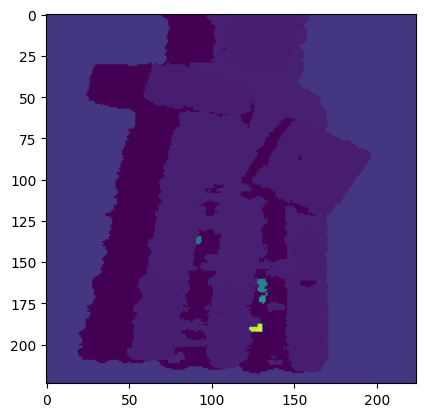

In [28]:
plt.imshow(depth[0])
plt.show()

In [29]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        self.double()

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))

        x = self.relu(self.batch_norm2(self.conv2(x)))

        x = self.conv3(x)
        x = self.batch_norm3(x)

        # downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        # add identity
        x += identity
        x = self.relu(x)
        return x


class Block(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        self.double()

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.batch_norm2(self.conv1(x)))
        x = self.batch_norm2(self.conv2(x))

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        print(x.shape)
        print(identity.shape)
        x += identity
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * ResBlock.expansion, num_classes)
        self.double()

    def forward(self, x):
        x = x.to(torch.double)
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes * ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes * ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes * ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes * ResBlock.expansion

        for i in range(blocks - 1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)

In [30]:
class CNN(nn.Module):
    def __init__(self):
        self.batch = 8
        self.depth_multiplier = 1 / 1000.0
        self.message = "Final Project of Xi Liu"
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    def ResNet50(self, num_classes, channels=3):
        return ResNet(Bottleneck, [3, 4, 6, 3], num_classes, channels)

    def ResNet101(self, num_classes, channels=3):
        return ResNet(Bottleneck, [3, 4, 23, 3], num_classes, channels)

    def ResNet152(self, num_classes, channels=3):
        return ResNet(Bottleneck, [3, 8, 36, 3], num_classes, channels)

    def array_to_tensor(self, array):
        return torch.stack(array, dim = 0)
    
    def depth_normalization(self, depth):
        for i0 in range(depth.shape[0]):
            for i1 in range(depth.shape[1]):
                for i2 in range(depth.shape[2]):
                    depth[i0][i1][i2] = self.depth_multiplier * (depth[i0][i1][i2] - min_depth) / (max_depth - min_depth)
        return depth

    def train_model(self, dataloader, model, loss_fn, optimizer, n_epoch):
        for e in range(n_epoch):
            model.train()
            # Print epoch
            print(f'Starting epoch {e + 1}')
            # Set current loss value
            current_loss = 0.0
            for batch_inx, data in enumerate(dataloader): # for batch_inx, (x, y) in enumerate(dataloader):
                """print('00', data[0][0].shape)
                print('01', data[0][1].shape)
                print('02', data[0][2].shape)
                print('03', data[0][3].transpose(1, 3).to(self.device).shape)"""
                img0 = data[0][0].to(self.device)
                img1 = data[0][1].to(self.device)
                img2 = data[0][2].to(self.device)
                depth = self.depth_normalization(data[0][3].transpose(1, 3).to(self.device))
                x = [img0, img1, img2, depth]
                x = self.array_to_tensor(x) # (img0, img1, img2, depth) batch x-pixel y-pixel color
                x = x.transpose(0, 1) # batch (img0, img1, img2, depth) x-pixel y-pixel color
                x = x.transpose(1, 4) # batch color x-pixel y-pixel (img0, img1, img2, depth)
                x = x.reshape(self.batch, 3, 224, 224 * 4)

                y = data[1].to(self.device) # torch.Size([8, 12])
                pred = model(x) # torch.Size([8, 12])
                """print('y', y.shape)
                print('pred', pred.shape)"""
                # pred *= 1000.0
                y *= 1000.0
                loss = loss_fn(pred, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # Print statistics
                current_loss += loss.item()
                if batch_inx % 10 == 0:
                    print('Loss after mini-batch %5d: %.3f' % (batch_inx + 1, current_loss / 10))
                    current_loss = 0.0
                del img0, img1, img2, depth, x, y, pred
        return model

    def main(self):
        model = self.ResNet101(num_classes=12, channels=3)
        model = model.to(self.device)

        loss_function = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        # read_prep_data = load('lx_preprocessed_data.joblib')
        # tr_data, tr_y, te_data = read_prep_data[0], read_prep_data[1], read_prep_data[2]

        # dataset_train = TensorDataset(Tensor(tr_data), Tensor(tr_y))
        # train_dataloader = DataLoader(dataset=data_train, batch_size=self.batch, shuffle=True, num_workers=2) # batchsize = 64
        train_dataloader = DataLoader(dataset=data_train, batch_size=self.batch, shuffle=True)

        # model = self.train_model(dataloader=train_dataloader, model=model, loss_fn=loss_function, optimizer=optimizer, n_epoch=30)
        model = self.train_model(dataloader=train_dataloader, model=model, loss_fn=loss_function, optimizer=optimizer, n_epoch=2)

        return model

    def pred(self, model_name):
        model = torch.jit.load(model_name)
        model.eval()

        # read_prep_data = load('lx_preprocessed_data.joblib')
        # tr_data, tr_y, te_data = read_prep_data[0], read_prep_data[1], read_prep_data[2]

        predictions = np.zeros(shape=(data_test.shape[0], 12))
        # dataset_test = TensorDataset(Tensor(te_data), Tensor(predictions))
        batch_size = 16
        test_dataloader = DataLoader(dataset=data_test, batch_size=batch_size, shuffle=True, num_workers=2)

        for batch_inx, (x, y) in enumerate(test_dataloader):
            x, y = x.to(self.device), y.to(self.device)
            test_pred = model(x)
            predictions[batch_inx*batch_size:(batch_inx+1)*batch_size, :] = test_pred.detach().cpu().numpy()
            if batch_inx % 10 == 0:
                print('Batch Index: ' + str(batch_inx))
        return predictions

In [31]:
print(torch.cuda.is_available())
torch.cuda.empty_cache()

True


In [32]:
model = CNN().main()

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.24 GiB already allocated; 14.41 MiB free; 2.24 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
!cat /var/colab/app.log

In [ ]:
class Submission:
    def __init__(self):
        self.message = "Submission"

    def submit(self):
        outfile = 'submission.csv'

        output_file = open(outfile, 'w')

        titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
                 'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']
        preds = []

        # test_data = torch.load('./test/test/testX.pt')
        # file_ids = test_data[-1]
        # rgb_data = test_data[0]
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(torch.cuda.is_available())
        torch.cuda.empty_cache()

        read_prep_data = load('preprocessed_testX.joblib')
        te_data = read_prep_data[0]
        file_ids = read_prep_data[1]
        file_ids = [int(numeric_string) for numeric_string in file_ids]
        print('finished load data')

        predictions = np.zeros(shape=(te_data.shape[0], 12))
        dataset_test = TensorDataset(Tensor(te_data), Tensor(predictions))
        batch_size = 8
        test_dataloader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, num_workers=2)
        print('finished prep test data')

        model = torch.jit.load('res50_pretrained_model.pt')
        model.eval()
        print('finished load model')

        for batch_inx, (x, y) in enumerate(test_dataloader):
            x, y = x.to(device), y.to(device)
            test_pred = model(x)
            predictions[batch_inx*batch_size:(batch_inx+1)*batch_size, :] = test_pred.detach().cpu().numpy()
            if batch_inx % 5 == 0:
                print('Batch Index: ' + str(batch_inx))

        # for i, data in enumerate(rgb_data):
        #     # Please remember to modify this loop, input and output based on your model/architecture
        #     output = model(data[:1, :, :, :].to('cuda'))
        #     preds.append(output[0].cpu().detach().numpy())
        # print(file_ids.shape)
        # print(predictions.shape)
        print('finished predict')
        df = pd.concat([pd.DataFrame(file_ids), pd.DataFrame(predictions)], axis=1, names=titles)
        df.columns = titles
        df.to_csv(outfile, index=False)
        print("Written to csv file {}".format(outfile))
        print('all finished')
        return df

In [ ]:
# sub = submission.Submission()
# df = sub.submit()

In [ ]:
print(df)